### Training an image classifier
1. Load and normalize the CIFAR10 training and test set using `torchvision`
2. Define a CNN
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10

In [64]:
import torch
import torchvision
import torchvision.transforms as transforms

In [65]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle = True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle = True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Files already downloaded and verified


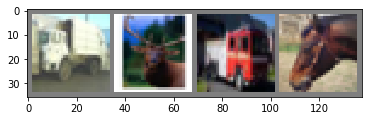

truck  deer truck horse


In [67]:
# plot some of the images
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define a CNN
*Note: these are 3-channel images

In [68]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum:

In [69]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network
This is where things get interesting. We simply have to loop over our data iterator and feed the inputs to the network and optimize:

In [71]:
for epoch in range(3):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print stats
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.231
[1,  4000] loss: 1.885
[1,  6000] loss: 1.711
[1,  8000] loss: 1.612
[1, 10000] loss: 1.513
[1, 12000] loss: 1.473
[2,  2000] loss: 1.395
[2,  4000] loss: 1.389
[2,  6000] loss: 1.374
[2,  8000] loss: 1.340
[2, 10000] loss: 1.325
[2, 12000] loss: 1.308
[3,  2000] loss: 1.256
[3,  4000] loss: 1.236
[3,  6000] loss: 1.234
[3,  8000] loss: 1.232
[3, 10000] loss: 1.188
[3, 12000] loss: 1.203
Finished Training


In [ ]:
# if we wanted, we can save our trained model by:
# PATH = './CIFAR_net.pth'
# torch.save(net.state_dict(), PATH)


### 5. Test the network on the test data
We've trained the network for 3 passes over the training set...but we need to check if the network has actually learnt anything.

We will check this by predictin the class label that the NN outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

First, we'll display an image from the test set to get familiar.

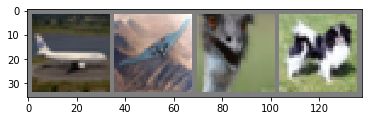

GroundTruth:  plane plane  bird   dog


In [72]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [73]:
# if we needed to load back our saved model, we could do so by:
# net = Net()
# net.load_state_dict(torch.load(PATH))

Okay, lets see what the NN we trained thinks these examples above are:

In [74]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:

In [75]:
p_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane plane  bird horse


3/4, not bad. That tiny dog was predicted to be a horse.

Let's look at how the network performs on the whole dataset:

In [76]:
correct, total = 0, 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


Welp, that's better than chance, which is 10% accuracy (10 classes)

What classes performed well and what did not perform well?

In [77]:
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 74 %
Accuracy of   car : 63 %
Accuracy of  bird : 51 %
Accuracy of   cat : 40 %
Accuracy of  deer : 46 %
Accuracy of   dog : 43 %
Accuracy of  frog : 67 %
Accuracy of horse : 57 %
Accuracy of  ship : 57 %
Accuracy of truck : 73 %
